# Scipy - Optimization of cumulative_simpson function
*March 28th 2023*

**Aim**
 - Compare different methods of implementing the Simpson's rule for cumulative integration of samples (at even or unequal intervals) and optimize.
 - Benchmark function against scipy.integrate.cumulative_trapezoid and scipy.integrate.simpson

**Purpose**

The Simpson's rule for numerical integration of samples is based on the assumption of a quadratic interpolation between 3 successive samples. This can be implemented in multiple ways, including as described in: https://en.wikipedia.org/wiki/Simpson%27s_rule. This notebook explores and compares the implementations.

## Import Dependencies

In [14]:
# Standard library imports
import os
import sys
from itertools import product, accumulate
from time import perf_counter
from typing import Optional

# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid, simpson
from scipy.interpolate import interp1d
from sympy import symbols, solve, collect, simplify, integrate, Eq, Integral, expand, factor, apart, cancel

np.random.seed = 42

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
def cumulative_simpson_equal(
    y: np.ndarray, x: Optional[np.ndarray] = None, dx: float = 1, initial: Optional[float] = 0,
) -> np.ndarray:
    """Simpson's 1/3 rule with equal intervals. 
    Assumes x consists of equally spaced points and has at least 3 points."""
    y = np.asarray(y)

    if x is not None:
        dx = (x[-1] - x[0])/(len(x) - 1)
    
    # Equation 2: Calculate sub-integrals (areas) for all but last area
    sub_integrals_h1 = dx/3 * (5*y[:-2]/4 + 2*y[1:-1] - y[2:]/4)
    sub_integrals_h1[1::2] = 0.0

    # Equation 3: Calculate sub-integrals (areas) for all but first area
    sub_integrals_h2 = dx/3 * (-y[:-2]/4 + 2*y[1:-1] + 5*y[2:]/4)
    sub_integrals_h2[1:-1:2] = 0.0

    sub_integrals = np.concatenate(
        [
            sub_integrals_h1[0:1],
            (sub_integrals_h1[1:] + sub_integrals_h2[:-1]),
            sub_integrals_h2[-1:],
        ]
    )
        
    integral = np.cumsum(sub_integrals)

    if initial is not None:
        initial = np.ones(len(y)) * initial
        initial[1:] += integral
        result = initial
    else:
        result = integral
    
    return result


def cumulative_simpson_equal_avg(
    y: np.ndarray, x: Optional[np.ndarray] = None, dx: float = 1, initial: Optional[float] = 0,
) -> np.ndarray:
    """Simpson's 1/3 rule with equal intervals. 
    Assumes x consists of equally spaced points and has at least 3 points.
    The integral over each interval is estimated by assuming a quadratic relation between the
    3 closest points. Derivation depicted here: 
    https://github.com/nprav/misc/blob/main/cumulative_simpson/Cumulative%20Simpson%20algorithm%20derivation.ipynb
    """
    y = np.asarray(y).astype(np.float64)

    if x is not None:
        dx = (x[-1] - x[0])/(len(x) - 1)
    
    # Equation 2: Calculate sub-integrals (areas) for all but last area
    sub_integrals_h1 = dx/3 * (5*y[:-2]/4 + 2*y[1:-1] - y[2:]/4)

    # Equation 3: Calculate sub-integrals (areas) for all but first area
    sub_integrals_h2 = dx/3 * (-y[:-2]/4 + 2*y[1:-1] + 5*y[2:]/4)

    if len(y) == 3:
        sub_integrals = np.concatenate((
            [sub_integrals_h1[0]],
            [sub_integrals_h2[-1]],
        ))
    else:
        sub_integrals = np.concatenate((
            [sub_integrals_h1[0]],
            (sub_integrals_h1[1:] + sub_integrals_h2[:-1])/2,
            [sub_integrals_h2[-1]],
        ))
    
    integral = np.cumsum(sub_integrals)

    if initial is not None:
        initial = np.ones(len(y)) * initial
        initial[1:] += integral
        result = initial
    else:
        result = integral
    
    return result

The equations match with what was derived earlier for the special case of equal intervals.

## Define Function to use Simpson's 1/3 rule for cumulative integration with unequal intervals

The function for unequal intervals is defined with the same logic as that for equal intervals, but with the updated integral formulae.

In [16]:
def cumulative_simpson_unequal(
    y: np.ndarray, x: Optional[np.ndarray] = None, dx: float = 1, 
    initial: Optional[float] = 0,
) -> np.ndarray:
    """Simpson's 1/3 rule with unequal intervals. 
    Assumes x has at least 3 points."""
    y = np.asarray(y)
    if x is not None:
        x = np.asarray(x)
    else:
        x = np.arange(0, dx*len(y), dx)

    d = np.diff(x)
    h1 = d[:-1]
    h2 = d[1:]
    y1 = y[:-2]
    y2 = y[1:-1]
    y3 = y[2:]
    
    # Equation 2: Calculate sub-integrals (areas) for all but last area
    sub_integrals_h1 = y1*(2*h1 + 3*h2)/(h1 + h2)*h1/6 + y2*(h1 + 3*h2)*h1/(6*h2) - y3*(h1**3/(6*h2))/(h1 + h2)
    sub_integrals_h1[1::2] = 0.0

    # Equation 3: Calculate sub-integrals (areas) for all but first area
    sub_integrals_h2 = -y1*(h2**3/(6*h1))/(h1 + h2) + y2*(3*h1 + h2)*h2/(6*h1) + y3*(3*h1 + 2*h2)/(h1 + h2)*h2/6
    sub_integrals_h2[1:-1:2] = 0.0

    sub_integrals = np.concatenate(
        [
            sub_integrals_h1[0:1],
            (sub_integrals_h1[1:] + sub_integrals_h2[:-1]),
            sub_integrals_h2[-1:],
        ]
    )
    
    integral = np.cumsum(sub_integrals)

    if initial is not None:
        initial = np.ones(len(y)) * initial
        initial[1:] += integral
        result = initial
    else:
        result = integral

    return result


def cumulative_simpson_unequal_avg(
    y: np.ndarray, x: Optional[np.ndarray] = None, dx: float = 1, 
    initial: Optional[float] = 0,
) -> np.ndarray:
    """Simpson's 1/3 rule with unequal intervals. 
    Assumes x has at least 3 points."""
    y = np.asarray(y).astype(np.float64)
    if x is not None:
        x = np.asarray(x).astype(np.float64)
    else:
        x = np.arange(0, dx*len(y), dx)

    d = np.diff(x)
    h1 = d[:-1]
    h2 = d[1:]
    y1 = y[:-2]
    y2 = y[1:-1]
    y3 = y[2:]
    
    # Equation 2: Calculate sub-integrals (areas) for all but last area
    sub_integrals_h1 = y1*(2*h1 + 3*h2)/(h1 + h2)*h1/6 + y2*(h1 + 3*h2)*h1/(6*h2) - y3*(h1**3/(6*h2))/(h1 + h2)

    # Equation 3: Calculate sub-integrals (areas) for all but first area
    sub_integrals_h2 = -y1*(h2**3/(6*h1))/(h1 + h2) + y2*(3*h1 + h2)*h2/(6*h1) + y3*(3*h1 + 2*h2)/(h1 + h2)*h2/6

    if len(y) == 3:
        sub_integrals = np.concatenate((
            [sub_integrals_h1[0]],
            [sub_integrals_h2[-1]],
        ))
    else:
        sub_integrals = np.concatenate((
            [sub_integrals_h1[0]],
            (sub_integrals_h1[1:] + sub_integrals_h2[:-1])/2,
            [sub_integrals_h2[-1]],
        ))
    
    integral = np.cumsum(sub_integrals)

    if initial is not None:
        initial = np.ones(len(y)) * initial
        initial[1:] += integral
        result = initial
    else:
        result = integral

    return result


def scipy_simps(    
    y: np.ndarray, x: Optional[np.ndarray] = None, dx: float = 1, 
    initial: Optional[float] = 0,
) -> np.ndarray:
    """Scipy Simpsons 1/3 rule implementation"""
    
    y = np.asarray(y)    
    if x is not None:
        x = np.asarray(x)
    else:
        x = np.arange(0, dx*len(y), dx)
    
    integral = np.array([simpson(y[:i], x[:i]) for i in range(2, len(y)+1)])

    if initial is not None:
        initial = np.ones(len(y)) * initial
        initial[1:] += integral
        result = initial
    else:
        result = integral

    return result

## Validate Integration Functions by Comparing to Theoretical Examples

Example function used:
- $y= sin(\alpha x)$, where $\alpha$ is a constant

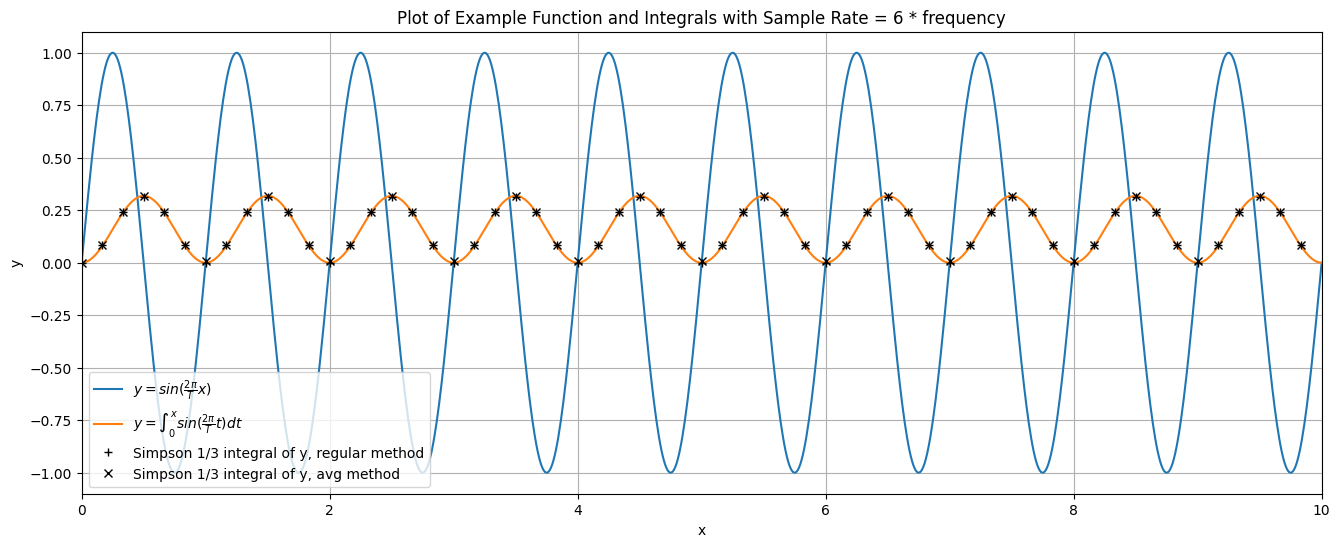

In [17]:
freq_y = 1
multiplier = 6
sample_freq_y = freq_y*multiplier
period_y = 1/freq_y
alpha = (2*np.pi/period_y)

t_max = 10
t = np.linspace(0, t_max, num=1000)
int_t = np.arange(0, t_max, 1/sample_freq_y)

def y(x):
    return np.sin(alpha*x)

def int_y(x):
    return (-np.cos(alpha*x) + 1)/alpha

simps_3_int_y = cumulative_simpson_equal(y(int_t), int_t, initial=0)

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(t, y(t), label=r"$y=sin(\frac{2\pi}{T} x)$")
ax.plot(t, int_y(t), label=r"$y=\int_0^x{sin(\frac{2\pi}{T} t) dt}$")
ax.plot(int_t, cumulative_simpson_equal(y(int_t), int_t, initial=0), 'k+', label="Simpson 1/3 integral of y, regular method")
ax.plot(int_t, cumulative_simpson_equal_avg(y(int_t), int_t, initial=0), 'kx', label="Simpson 1/3 integral of y, avg method")
ax.set(xlabel="x", ylabel="y", xlim=(0, t_max), 
       title=f"Plot of Example Function and Integrals with Sample Rate = {multiplier} * frequency")
ax.legend(loc="lower left")
ax.grid()

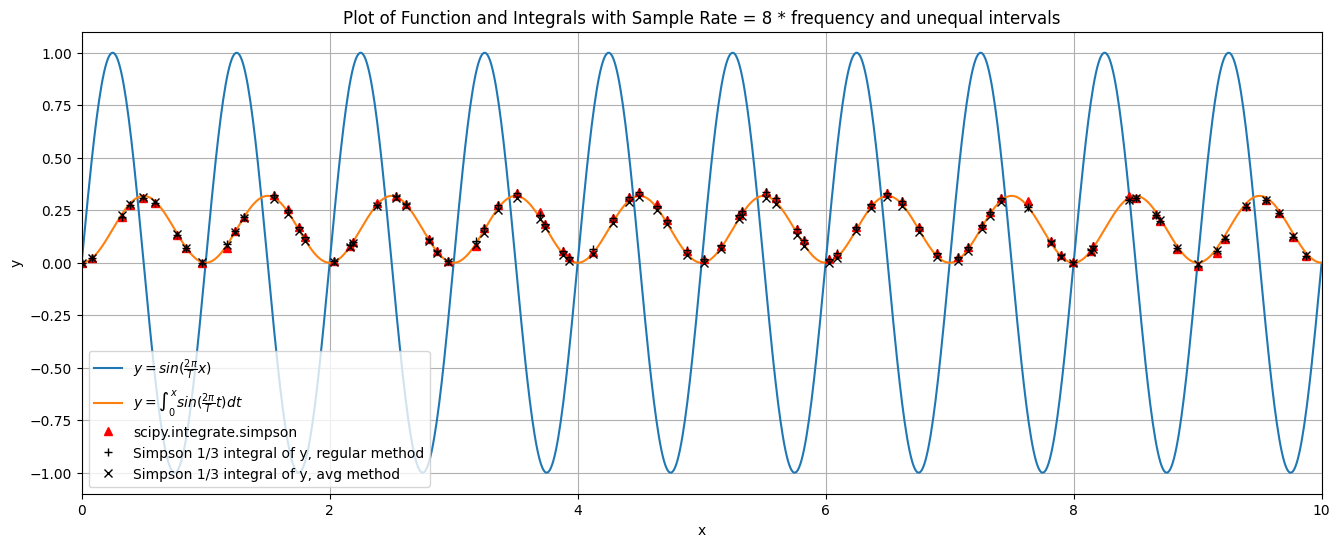

In [18]:
freq_y = 1
multiplier = 8
sample_freq_y = freq_y*multiplier
period_y = 1/freq_y
alpha = (2*np.pi/period_y)

t_max = 10
t = np.linspace(0, t_max, num=1000)
int_t = np.arange(0, t_max, 1/sample_freq_y)
int_t[1:-1] += np.random.normal(loc=0, scale=1, size=len(int_t)-2)*0.3*(1/sample_freq_y)

def y(x):
    return np.sin(alpha*x)

def int_y(x):
    return (-np.cos(alpha*x) + 1)/alpha

sp_simps_int_y = scipy_simps(y(int_t), int_t, initial=0)

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(t, y(t), label=r"$y=sin(\frac{2\pi}{T} x)$")
ax.plot(t, int_y(t), label=r"$y=\int_0^x{sin(\frac{2\pi}{T} t) dt}$")
ax.plot(int_t, sp_simps_int_y, 'r^', label="scipy.integrate.simpson")
ax.plot(int_t, cumulative_simpson_unequal(y(int_t), int_t, initial=0), 'k+', label="Simpson 1/3 integral of y, regular method")
ax.plot(int_t, cumulative_simpson_unequal_avg(y(int_t), int_t, initial=0), 'kx', label="Simpson 1/3 integral of y, avg method")
ax.set(xlabel="x", ylabel="y", xlim=(0, t_max), 
       title=f"Plot of Function and Integrals with Sample Rate = {multiplier} * frequency and unequal intervals")
ax.legend(loc="lower left")
ax.grid()

The black points match the orange line --> this validates the cumulative_simpson implementation

## Quantify Errors

- Calculate the average error in the numerical integration over multiple sample rates (number of integration points).
- Plot the average error for different numerical integration methods over the range of sample rates.

In [19]:
from itertools import product

sample_rate = np.linspace(4, 50, num=100)
int_range = max(int_y(t)) - min(int_y(t))

def get_mean_error(cum_int_func, int_t, func=y, int_func=int_y):
    int_range = max(int_func(int_t)) - min(int_func(int_t))
    res = cum_int_func(func(int_t), int_t, initial=0)
    error = np.mean(np.abs(int_func(int_t) - res))/int_range
    return error

errors = {
    cumulative_simpson_equal: [],
    cumulative_simpson_equal_avg: [],
    cumulative_simpson_unequal: [],
    cumulative_trapezoid: [],
    scipy_simps: [],
}
for sr, int_func in product(sample_rate, errors):
    int_t = np.arange(0, t_max, 1/sr)
    errors[int_func].append(get_mean_error(int_func, int_t))

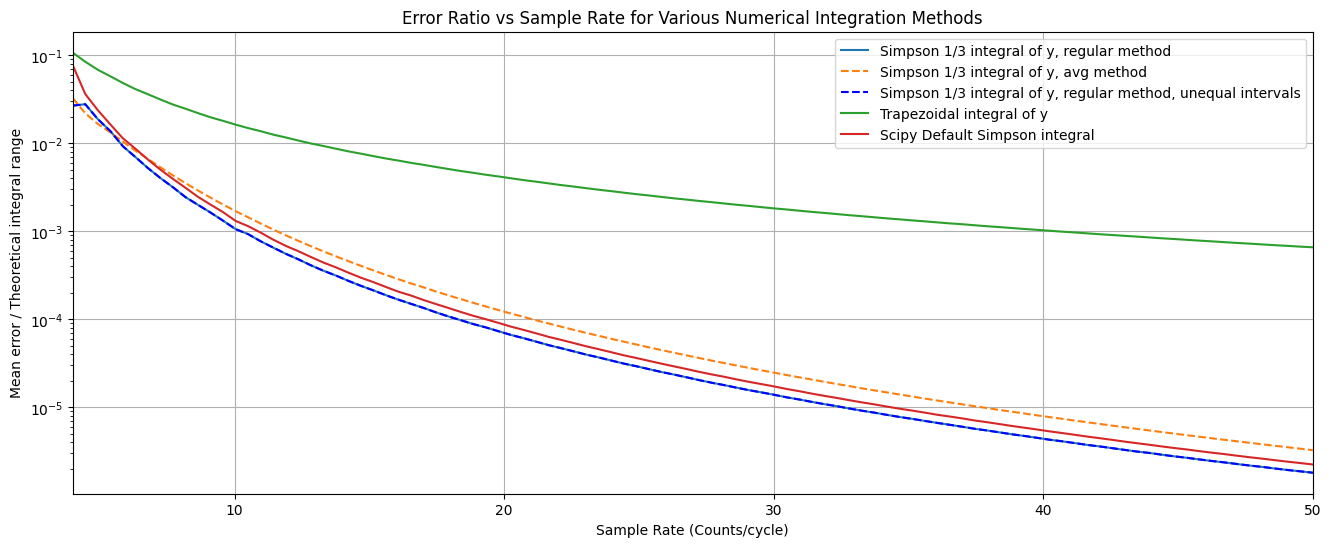

In [20]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.semilogy(sample_rate, errors[cumulative_simpson_equal], label="Simpson 1/3 integral of y, regular method")
ax.semilogy(sample_rate, errors[cumulative_simpson_equal_avg], '--', label="Simpson 1/3 integral of y, avg method")
ax.semilogy(sample_rate, errors[cumulative_simpson_unequal], 'b--', label="Simpson 1/3 integral of y, regular method, unequal intervals")
ax.semilogy(sample_rate, errors[cumulative_trapezoid], label="Trapezoidal integral of y")
ax.semilogy(sample_rate, errors[scipy_simps], label="Scipy Default Simpson integral")
ax.grid()
ax.set(xlim=(min(sample_rate), max(sample_rate)), xlabel="Sample Rate (Counts/cycle)", 
       ylabel="Mean error / Theoretical integral range", 
       title="Error Ratio vs Sample Rate for Various Numerical Integration Methods")
ax.legend()

In [21]:
sample_rate = np.linspace(4, 40, num=100)
int_range = max(int_y(t)) - min(int_y(t))
num_repeats = 5

def get_uneven_int_t(t_min, t_max, sr):
    int_t = np.arange(t_min, t_max, 1/sr)
    int_t[1:-1] += np.random.normal(loc=0, scale=1, size=len(int_t)-2)*0.3*(1/sr)
    return int_t

errors2 = {
    cumulative_simpson_unequal: [],
    cumulative_simpson_unequal_avg: [],
    cumulative_trapezoid: [],
    scipy_simps: [],
}
for sr in sample_rate:
    int_t_arr = [get_uneven_int_t(0, t_max, sr) for i in range(num_repeats)]
    for int_func in errors2:
        errors2[int_func].append(
            np.mean([get_mean_error(int_func, int_t) for int_t in int_t_arr])
        )

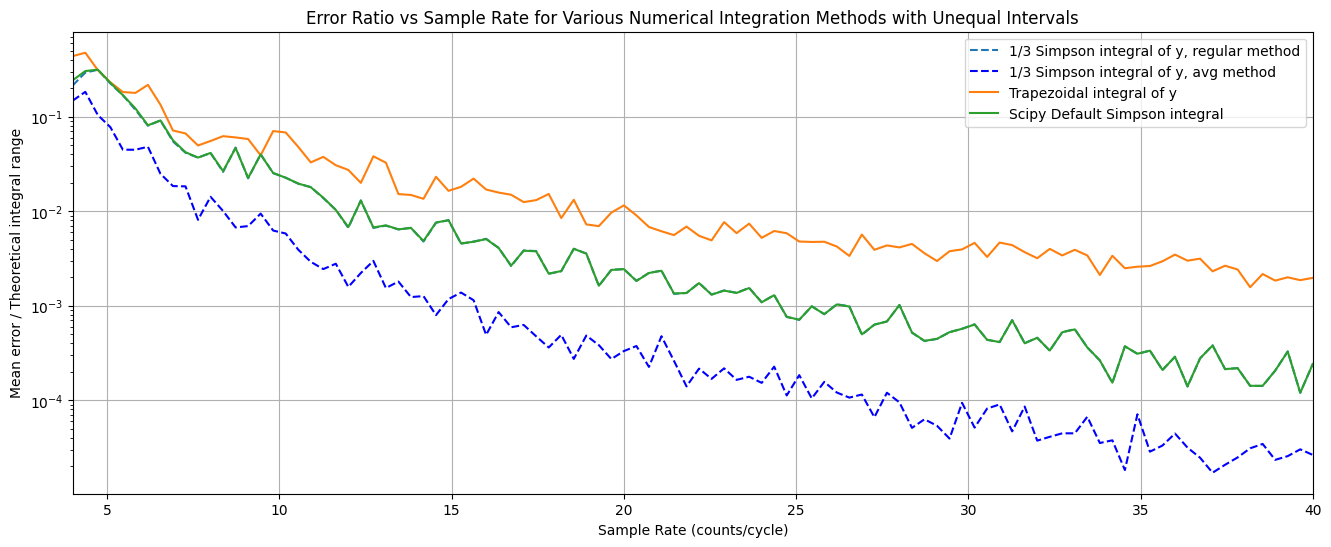

In [22]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.semilogy(sample_rate, errors2[cumulative_simpson_unequal], '--', label="1/3 Simpson integral of y, regular method")
ax.semilogy(sample_rate, errors2[cumulative_simpson_unequal_avg], 'b--', label="1/3 Simpson integral of y, avg method")
ax.semilogy(sample_rate, errors2[cumulative_trapezoid], label="Trapezoidal integral of y")
ax.semilogy(sample_rate, errors2[scipy_simps], label="Scipy Default Simpson integral")
ax.grid()
ax.set(xlim=(min(sample_rate), max(sample_rate)), xlabel="Sample Rate (counts/cycle)", 
       ylabel="Mean error / Theoretical integral range", 
       title="Error Ratio vs Sample Rate for Various Numerical Integration Methods with Unequal Intervals")
ax.legend()

### Accuracy Conclusions

Observations:
- The cumulative simpson's rule implementations are orders of magnitude more accurate than the Trapezoidal rule.
- When functions are well behaved (equal intervals/ many points between each inflection point/curve) the classical Simpson's rule implementation is slightly more accurate.
- When functions are less well behaved (unequal intervals/ fewer points between each inflection point/curve) the average method implementation is significantly more accurate than the regular Simpson's rule.
- The cumulative simpson function is similar or better in accuracy than the current scipy.integrate.simpson implementation for these examples.

## Quantify Timing

In [23]:
def time_func(func, max_time=2, num_runs=5, func_name=None):
    cts_per_run = []
    for run in range(num_runs):
        t_ct = t0 = perf_counter()
        ct = 0
        while t_ct - t0 < max_time/num_runs:
            func()
            ct += 1
            t_ct = perf_counter()
        cts_per_run.append(ct)
    best_ct = max(cts_per_run)
    loop_time = (max_time/num_runs)/best_ct
    if func_name is not None:
        print(func_name + ":")
    print(f"{best_ct} loops in {max_time/num_runs:.3f}s, best of {num_runs}: {loop_time:.3e}s per loop")
    return loop_time

In [24]:
methods = {
    "trapezoidal": cumulative_trapezoid,
    "simpson's 1/3 rule": cumulative_simpson_equal,
    "simpson's 1/3 rule with unequal intervals": cumulative_simpson_unequal,
    "simpson's 1/3 rule, avg method": cumulative_simpson_equal_avg,
    "simpson's 1/3 rule with unequal intervals, avg method": cumulative_simpson_unequal_avg,
}
time_func(lambda: scipy_simps(y(int_t), int_t, initial=0), func_name="scipy.integrate.simpson")
timing = [time_func(lambda: func(y(int_t), int_t, initial=0), func_name=key) for key, func in methods.items()]

scipy.integrate.simpson:
11 loops in 0.400s, best of 5: 3.636e-02s per loop
trapezoidal:
15741 loops in 0.400s, best of 5: 2.541e-05s per loop
simpson's 1/3 rule:
6512 loops in 0.400s, best of 5: 6.143e-05s per loop
simpson's 1/3 rule with unequal intervals:
3345 loops in 0.400s, best of 5: 1.196e-04s per loop
simpson's 1/3 rule, avg method:
8124 loops in 0.400s, best of 5: 4.924e-05s per loop
simpson's 1/3 rule with unequal intervals, avg method:
3838 loops in 0.400s, best of 5: 1.042e-04s per loop


In [25]:
num_pts = [100, 1000, 10000]
timing_results = {key: [] for key in methods.keys()}
for num, func_name in product(num_pts, timing_results):
    int_t = np.linspace(0, t_max, num=num)
    func = methods[func_name]
    timing_results[func_name].append(
        time_func(lambda: func(y(int_t), int_t, initial=0), func_name=func_name)
    )

trapezoidal:
21957 loops in 0.400s, best of 5: 1.822e-05s per loop
simpson's 1/3 rule:
10655 loops in 0.400s, best of 5: 3.754e-05s per loop
simpson's 1/3 rule with unequal intervals:
5533 loops in 0.400s, best of 5: 7.229e-05s per loop
simpson's 1/3 rule, avg method:
9769 loops in 0.400s, best of 5: 4.095e-05s per loop
simpson's 1/3 rule with unequal intervals, avg method:
5776 loops in 0.400s, best of 5: 6.925e-05s per loop
trapezoidal:
13107 loops in 0.400s, best of 5: 3.052e-05s per loop
simpson's 1/3 rule:
6775 loops in 0.400s, best of 5: 5.904e-05s per loop
simpson's 1/3 rule with unequal intervals:
2386 loops in 0.400s, best of 5: 1.676e-04s per loop
simpson's 1/3 rule, avg method:
6163 loops in 0.400s, best of 5: 6.490e-05s per loop
simpson's 1/3 rule with unequal intervals, avg method:
2668 loops in 0.400s, best of 5: 1.499e-04s per loop
trapezoidal:
2769 loops in 0.400s, best of 5: 1.445e-04s per loop
simpson's 1/3 rule:
1412 loops in 0.400s, best of 5: 2.833e-04s per loop
si

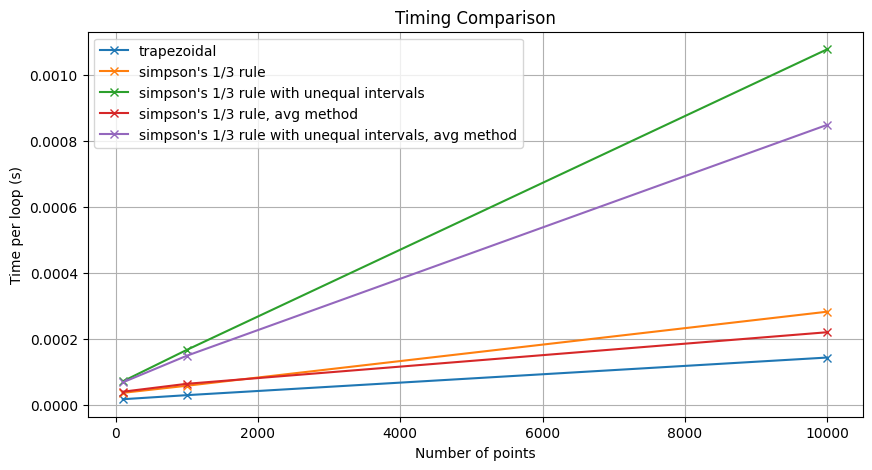

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(timing))
for key, value in timing_results.items():
    ax.plot(num_pts, value, 'x-', label=key)
ax.set(
    xlabel="Number of points",
    ylabel="Time per loop (s)",
    title="Timing Comparison",
)
ax.legend()
ax.grid()

Custom trapezoidal integration function is the most performant, but cumulative_simpson functions defined are also O(n) time and space.